# Error surface based Bayesian Inversion for two layer splitting

Bayes theorem can be stated: 

$P(A) = P(A|B) \frac{P(B)}{P(B|A)}$

Assume we have an S wave with splitting at source and receiver.

* $P(A)$ is the pdf of the source splitting (unknown).
* $P(B)$ is the pdf of the receiver splitting (constrained from prior knowledge).
* $P(A|B)$ is the pdf of the receiver corrected measurement.
* $P(B|A)$ is the pdf of the source corrected measurement.

Ideally $P(A) = P(A|B)$ and $P(B) = P(B|A)$.

Give prior knowledge of $P(B)$ e.g. from SKS, we can iterate to find $P(A)$.

The algorithm should seek to minimise $abs[P(B)-P(B|A)]$. 

First:

* Choose splitting parameters from $P(B)$.
* Measure $P(A|B_i)$.  

Normally we select $B_i$ to be the most likely parameter from $B$ and then
assume that $P(A)=P(A|B)$.  In my srcside S paper I made multiple choices
of $B_i$ and used these to derive a better sampled $P(A|B)$ which I then
assumed was equal to $P(A)$. i.e.

$P(A) \sim P(A|B) \sim \frac{1}{N} \Sigma_{i=1}^{N} P(A|B_i)$

Can we do better? What if we flip this around:

$P(B|A) \sim \frac{1}{N} \Sigma_{i=1}^{N} P(B|A_i)$

We can then test how well the method is working.  If it works well:

$P(B) \sim P(B|A)$, i.e.,
abs[$P(B) - P(B|A)$] should be minimised.

If not we may can try a new $P(B)$ and attempt to optimise.

Rather than use the whole error surfaces, can we use "squashed" profiles?  We 

* Use a random sampling 



* Measure $P(B|A)$.  Assume $P(A) \sim P(A|B)$.
* Calculate $P(B) - P(B|A)$.
- We can stop here if difference is acceptably small.
- Otherwise iterate.
* Update $P(B) = P(B|A)$ and repeat.


# Synthetic Example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# import sys
# sys.path.append("..")
import splitwavepy as sw

import numpy as np
import matplotlib.pyplot as plt

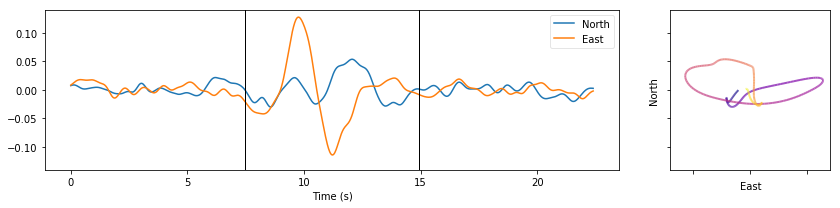

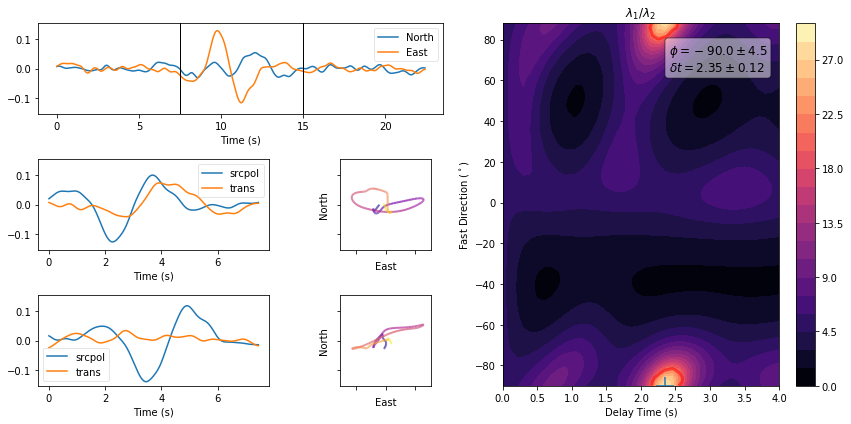

In [14]:
# Generate a synthetic and add source and receiver splitting
srcfast, srclag = 30, 1.1
rcvfast, rcvlag = 70, 1.5

# Generate a synthetic
a = sw.Data(split=[(srcfast,srclag),(rcvfast,rcvlag)],delta=0.025,noise=0.05)
a.plot()

# A measurement
m = a.SC(lags=(4,), bootstrap=True)
m.plot()




Generate a synthetic receiver correction. And thus create $P(B)$.

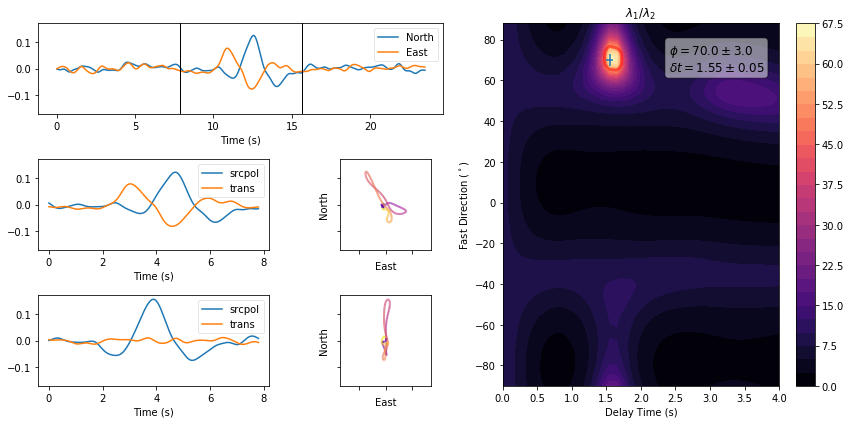

In [20]:
# Generate a receiver correction
pbM = sw.Data(split=(rcvfast, rcvlag), delta=0.025, noise=0.05).SC(lags=(4,), bootstrap=True)
pbM.plot()
pb = pbM.estimate_pdf()

Measure $P(A|B)$ (rcvcorrected data)

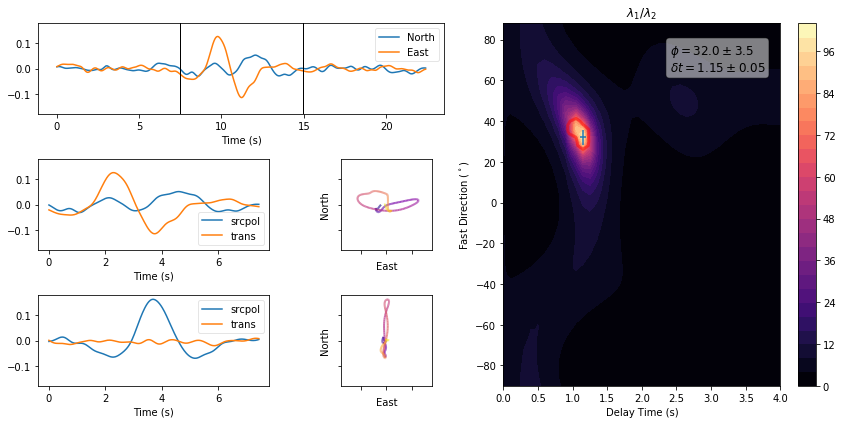

In [21]:
pabM = a.SC(rcvcorr=(pbM.fast,pbM.lag), lags=(4,), bootstrap=True)
pabM.plot()
pab = pabM.estimate_pdf()

Measure $P(B|A)$ (srccorrected data)

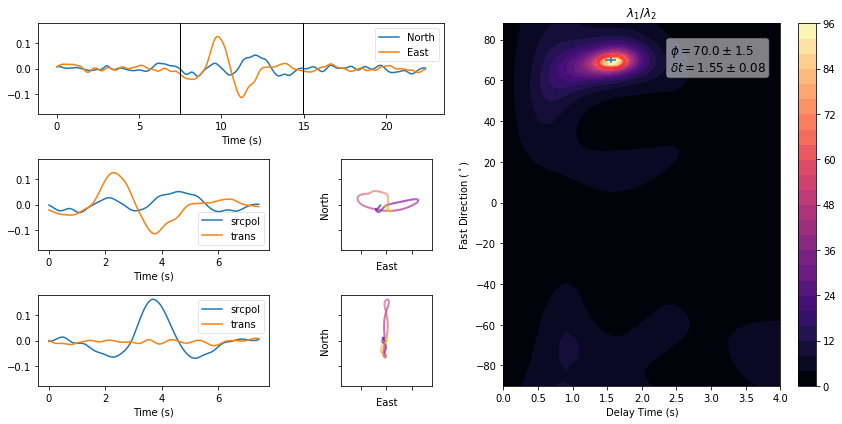

In [22]:
pbaM = a.SC(srccorr=(pabM.fast,pabM.lag), lags=(4,), bootstrap=True)
pbaM.plot()
pba = pbaM.estimate_pdf()

Evaluate $P(B) - P(B|A)$.

Total difference = 1.29571211351


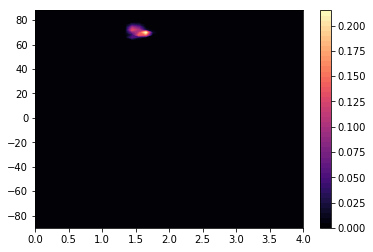

In [23]:
pb_pba = abs(pbMpdf-pbaMpdf)
plt.contourf(*pbM._grid(), pb_pba, 50, cmap='magma')
plt.colorbar()
# plot_surf(lags,degs,pb_pba)
total_diff = np.sum(pb_pba)
print('Total difference =',total_diff)

Evaluate $P(A)$

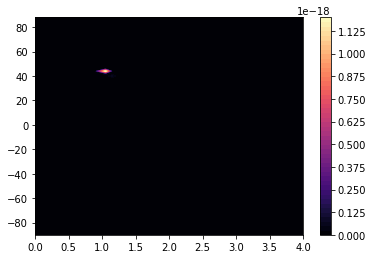

In [26]:
pa = pab * (pb/pba)
plt.contourf(*pbM._grid(), pa, 50, cmap='magma')
plt.colorbar()
#     print(get_parms(degs,lags,pa))

Update $P(B)$ and repeat.

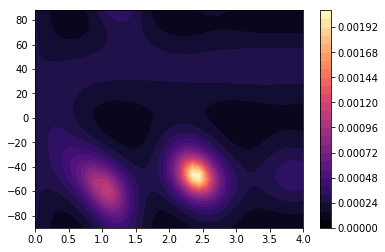

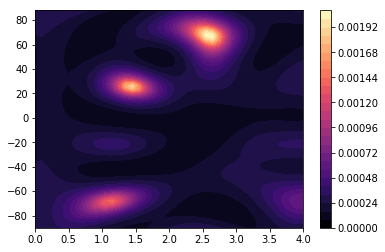

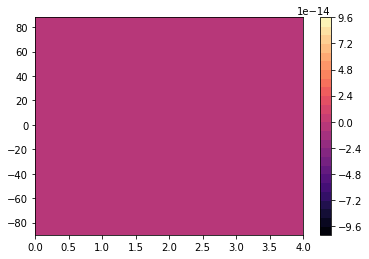

Total difference = 0.0


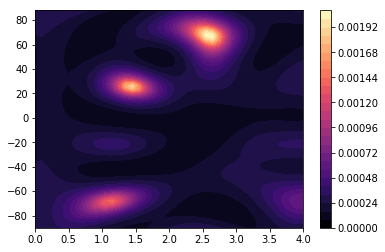

(68.0, 2.5500000000000003)


In [126]:
# update pbM by replacing with pbaM
pbM = pbaM
pb = pba

# measure p(a|b) (rcvcorrected a)
pabM = sw.EigenM(a,rcvcorr=(pbM.fast,pbM.lag),lags=(4,))
pab = (pabM.lam1/pabM.lam2)
pab = pab / np.sum(pab)
plot_surf(lags, degs, pab)
# plt.set_title(r'P(A|B)')

# measure p(b|a) (srccorrected b)
pbaM = sw.EigenM(a,srccorr=(pabM.fast,pabM.lag),lags=(4,))
pba = (pbaM.lam1/pbaM.lam2)
pba = pba / np.sum(pba)
plot_surf(lags, degs, pba)

# evaluate p(b) - p(b|a)
pb_pba = abs(pb-pba)
plot_surf(lags,degs,pb_pba)
total_diff = np.sum(pb_pba)
print('Total difference =',total_diff)

# evaluate p(a)
pa = pab * (pb/pab)
plot_surf(lags,degs,pa)
print(get_parms(degs,lags,pb))

In [108]:


# # Generate a synthetic and add source and receiver splitting
# srcfast, srclag = 30, 1.1
# rcvfast, rcvlag = 70, 1.5
# a = sw.Pair(split=[(srcfast,srclag),(rcvfast,rcvlag)],delta=0.025,noise=0.05)

# # Generate a receiver correction
# pbM = sw.EigenM(split=(rcvfast+5,rcvlag+.3),delta=0.025,noise=0.05,lags=(4,))
# # Normalise lambda1/lamda2 and assume this is the PDF.
# pb = (pbM.lam1/pbM.lam2)
# pb = pb / np.sum(pb)

# update pbM by replacing with pbaM
pbM = pbaM
pb = pba

# measure p(a|b) (rcvcorrected a)
pabM = sw.EigenM(a,rcvcorr=(pbM.fast,pbM.lag),lags=(4,))
pab = (pabM.lam1/pabM.lam2)
pab = pab / np.sum(pab)
# plot_surf(lags, degs, pab)
# plt.set_title(r'P(A|B)')

# measure p(b|a) (srccorrected b)
pbaM = sw.EigenM(a,srccorr=(pabM.fast,pabM.lag),lags=(4,))
pba = (pbaM.lam1/pbaM.lam2)
pba = pba / np.sum(pba)
# plot_surf(lags, degs, pba)

# evaluate p(b) - p(b|a)
pb_pba = abs(pb-pba)
# plot_surf(lags,degs,pb_pba)
total_diff = np.sum(pb_pba)
print('Total difference =',total_diff)

# evaluate p(a)
pa = pab * (pb/pab)
fast, lag = get_parms(degs,lags,pa)
print('Source-side splitting =',fast,lag)
# plot_surf(lags,degs,pa)

Total difference = 0.0
Source-side splitting = 76.0 1.35


In [13]:
pbM.estimate_pdf()

array([[  8.02649195e-49,   8.02649195e-49,   8.02649195e-49, ...,
          8.02649195e-49,   8.02649195e-49,   8.02649195e-49],
       [  4.47312865e-51,   3.33838531e-51,   2.62765039e-51, ...,
          1.39007311e-50,   9.19461142e-51,   6.28444382e-51],
       [  4.90990480e-58,   1.79809140e-58,   7.93830011e-59, ...,
          2.64202948e-56,   6.06099910e-57,   1.59481404e-57],
       ..., 
       [  1.50792122e-81,   4.88176273e-83,   2.45562918e-84, ...,
          7.38367320e-76,   5.73634096e-78,   7.33519415e-80],
       [  1.29799132e-82,   4.67683073e-84,   2.50982696e-85, ...,
          3.49141840e-77,   3.47940927e-79,   5.42651697e-81],
       [  1.90516332e-83,   7.20296228e-85,   3.89996367e-86, ...,
          3.54854552e-78,   4.14887519e-80,   7.31244812e-82]])